In [1]:
from utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare
import pickle

In [2]:
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"
season = "1415"
df = get_match_data(base_url.format(season)).sort_values(by="MatchWeek")
ws = get_winstreak(df)

In [3]:
week_split = 25
train = df[df["MatchWeek"]<=week_split]
test = df[df["MatchWeek"]>week_split]

In [5]:
### Train params

params = np.ones((4,20))

num_itrs = 200000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = train.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]

        # update home team params
        params[0,home_index] += lr * (home_goal / params[0,home_index] - params[3,away_index])
        params[1,home_index] += lr * (away_goal / params[1,home_index] - params[2,away_index])

        # update away team params
        params[2,away_index] += lr * (away_goal / params[2,away_index] - params[1,home_index])
        params[3,away_index] += lr * (home_goal / params[3,away_index] - params[0,home_index])

100%|██████████| 200000/200000 [06:13<00:00, 535.89it/s]


In [8]:
# ### Save trained params DON'T UNCOMMENT
# ### Params trained with itrs=200,000, lr=0.0001
# saved_params = params
# with open('saved_data/betting_params.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_params, f, pickle.HIGHEST_PROTOCOL)

In [40]:
with open('saved_data/betting_params.pickle', 'rb') as f:
    saved_params = pickle.load(f)

params = saved_params

In [42]:
current = 100.00
history = [current]
matchweek = [week_split]
games_played = week_split
for name, group in test.groupby("MatchWeek"):
    for i, row in group.iterrows():
        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        result = row["FTR"]
        
        house_odds = np.array([row["B365H"], row["B365D"], row["B365A"]])
        model_odds = get_odds(params, home_index, away_index)
        x = current

        current = place_bet(current, house_odds, model_odds, result)
        # if current < x:
        #     print(row["HomeTeam"], row["AwayTeam"], model_odds, house_odds)
    games_played += 1
    history.append(current)
    matchweek.append(games_played)
# plt.plot(history)

In [34]:
home_index = teams_ind["Southampton"]
away_index = teams_ind["Liverpool"]
get_odds(params, home_index, away_index)

home_goal_param = params[0, home_index] * params[3, away_index]
away_goal_param = params[1, home_index] * params[2, away_index]

scores = np.zeros((16,16))
for i in range(16):
    for j in range(16):
        scores[i,j] = poisson.pmf(i, home_goal_param) * poisson.pmf(j, away_goal_param)
print(params[:, home_index], params[:, away_index])

[1.54067551 0.55455188 1.04197585 0.62961258] [1.30922641 1.00389284 1.13807306 1.20024985]


In [43]:
# Simpler model to compare

train_standings = get_standings(train)
games_played = week_split
curr_goals = sum(train_standings["GF"])
team_goals = np.zeros((2,20))
simple_params = np.zeros((2,20))
for j, team in train_standings.iterrows():
    i = teams_ind[team["Team"]]
    team_goals[0,i] = team["GF"]
    team_goals[1,i] = team["GA"]
simple_params = (team_goals / games_played) / (curr_goals / (games_played*20))

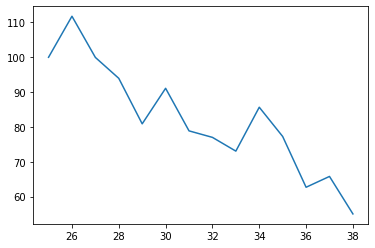

In [36]:
current = 100.00
games_played = week_split
history2 = [current]
matchweek=[games_played]
results_dict = {0: "H", 1: "D", 2: "A"}

for name, group in test.groupby("MatchWeek"):
    for i, row in group.iterrows():
        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        result = row["FTR"]
        
        house_odds = np.array([row["B365H"], row["B365D"], row["B365A"]])
        model_odds = get_odds(simple_params, home_index, away_index, complex=False)

        current = place_bet(current, house_odds, model_odds, result)
        
        # Update counters
        team_goals[0,home_index] += row["FTHG"]
        team_goals[1,away_index] += row["FTHG"]
        team_goals[0,away_index] += row["FTAG"]
        team_goals[1,home_index] += row["FTAG"]
        curr_goals += (row["FTHG"] + row["FTAG"])

    games_played += 1
    simple_params = (team_goals / games_played) / (curr_goals / (games_played*20))
    history2.append(current)
    matchweek.append(games_played)

# plt.plot(matchweek, history2)

Text(0.5, 1.0, 'Model performance over time')

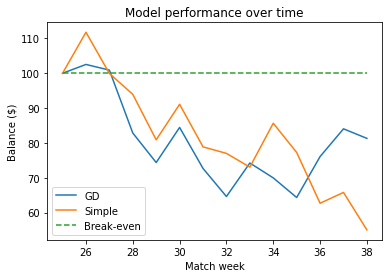

In [44]:
plt.plot(matchweek, history, label="GD")
plt.plot(matchweek, history2, label="Simple")
plt.plot(matchweek, [100 for i in range(14)], '--', label="Break-even")
plt.legend()
plt.xlabel("Match week")
plt.ylabel("Balance ($)")
plt.title("Model performance over time")
# plt.savefig("figures/betting.jpeg", dpi=300)